In [8]:
import os
os.chdir('../..')

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

from coffea.util import load
from coffea.hist import plot
import numpy as np
import pandas as pd

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import torch
from torch import nn
from torch import optim

from math import floor

In [2]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/parton_matching_dR03_v08/output.coffea" 
output = load(filename1)
output.keys()

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_nparton', 'hist_parton_pt', 'hist_parton_eta', 'hist_parton_phi', 'hist_parton_pdgId', 'hist_npartonmatched', 'hist_partonmatched_pt', 'hist_partonmatched_eta', 'hist_partonmatched_pdgId', 'hist2d_Njet_Nparton_total', 'hist2d_Njet_Nparton_matched', 'hist2d_Nparton_Nparton_matched', 'columns', 'hist_ptComparison_parton_matching', 'hist_deltaR_parton_matching', 'scale_genweight'])

In [3]:
df_sig = pd.DataFrame({k: v['ttHTobb'].value for k, v in output["columns"]['4j'].items()  if k != "njet_matched"})
df_tt = pd.DataFrame({k: v['TTToSemiLeptonic'].value for k, v in output["columns"]['4j'].items()  if k != "njet_matched"})

In [7]:
df_tt

,parton_pt,parton_pdgId,jet_pt,jet_eta,parton_jet_dR,jet_btag
0,222.156250,-5,216.87500,-0.755249,0.288756,0.989258
1,155.625000,2,157.75000,0.736084,0.071680,0.001937
2,116.113281,5,117.25000,1.065674,0.096004,0.998535
3,57.958984,-1,55.78125,0.045135,0.137975,0.011711
4,124.378906,3,153.87500,-0.175293,0.010272,0.002636
...,...,...,...,...,...,...
27595783,68.566406,5,38.96875,0.347046,0.293948,0.999512
27595784,122.984375,5,116.31250,0.354980,0.140990,0.311035
27595785,106.871094,-5,101.56250,-0.699097,0.021968,0.997070
27595786,56.589844,4,52.21875,0.378906,0.097017,0.068604


In [28]:
inputs_pts = df_tt[["parton_pt","jet_pt",]].values[0:2000000]

In [ ]:
count, ybins,xbins, im = plt.hist2d(inputs_pts[:,0],inputs_pts[:,1], bins=100, range=((0,300),(20, 300) ), norm=LogNorm())
plt.ylabel("Jet Pt")
plt.xlabel("Parton Pt")
plt.contour(count, levels=30, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())
#plt.colorbar()

In [ ]:
features,
        

In [169]:
from nflows import transforms, distributions, flows
from nflows.transforms.permutations import ReversePermutation

# Define an invertible transformation.
transform = transforms.CompositeTransform([
    ReversePermutation(features=2),
    transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=4)
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[2])


# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)

optimizer = optim.Adam(flow.parameters())

In [24]:
from nflows.flows.autoregressive import MaskedAutoregressiveFlow

flow = MaskedAutoregressiveFlow(
    features = 2, 
    hidden_features=5,
    num_layers=4,
    num_blocks_per_layer=1,
    use_residual_blocks=True,
    use_random_masks=False,
    use_random_permutations=True,
    dropout_probability=0.00,
    batch_norm_within_layers=True,
    batch_norm_between_layers=False)

optimizer = optim.Adam(flow.parameters())

In [25]:
flow

MaskedAutoregressiveFlow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): RandomPermutation()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=5, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (batch_norm_layers): ModuleList(
                (0): BatchNorm1d(5, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (1): BatchNorm1d(5, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              )
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=5, out_features=5, bias=True)
                (1): MaskedLinear(in_features=5, out_features=5, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=5, out_features=4, bias=True)
     

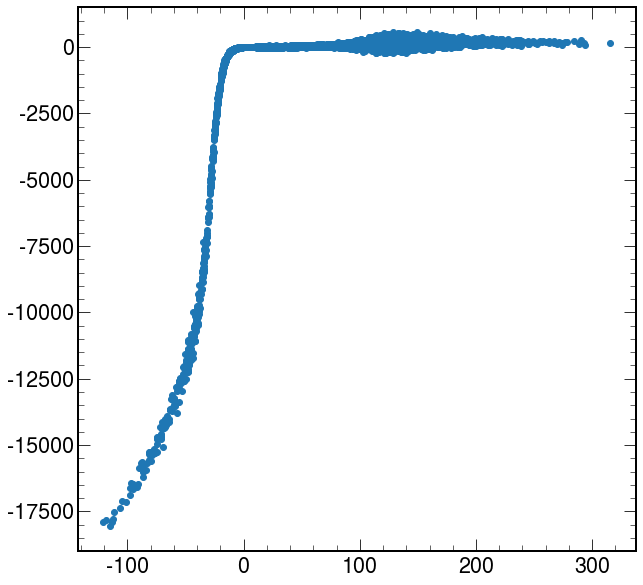

In [30]:
samples = flow.sample(10000).detach().numpy()
plt.scatter(samples[:,0], 
            samples[:,1])

In [21]:
def plot_density(flow, title="", xrange=[-5,5], yrange=[-5,5]):
    plt.figure(figsize=(5,5))
    xline = torch.linspace(*xrange, 100)
    yline = torch.linspace(*yrange, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy(), 20, cmap="Blues")
    plt.title(title)
    plt.show()

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


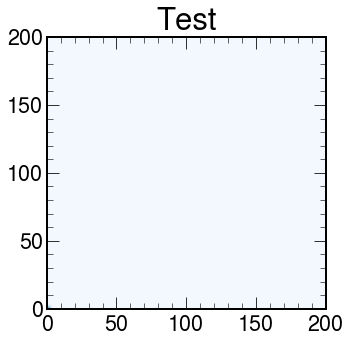

In [12]:
plot_density(flow, "Test", [0,200], [0,200])

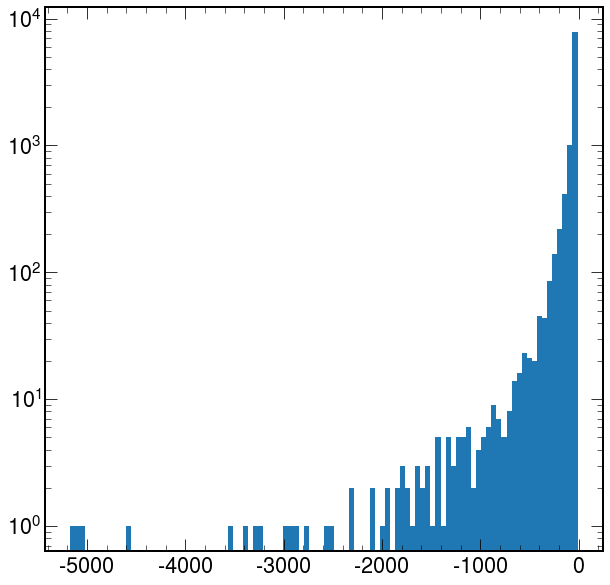

In [13]:
prob = flow.log_prob(inputs_pts[0:10000]).detach().numpy()
plt.hist(prob, bins=100)
plt.yscale("log")

# Training

	Step: 0, loss: 2465.69775390625
	Step: 1000, loss: 29.288471221923828
Epoch 0: loss: 56.43056106567383


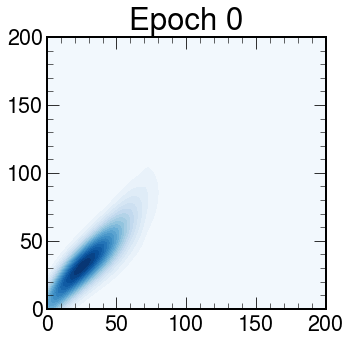

	Step: 0, loss: 14.413817405700684
	Step: 1000, loss: 11.191516876220703
Epoch 1: loss: 11.475308418273926


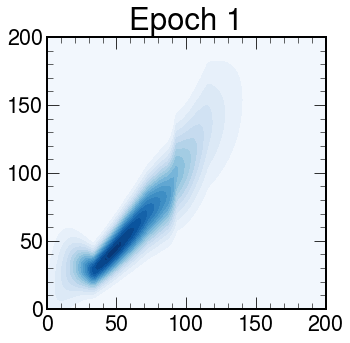

	Step: 0, loss: 10.492916107177734
	Step: 1000, loss: 10.037638664245605
Epoch 2: loss: 10.03180980682373


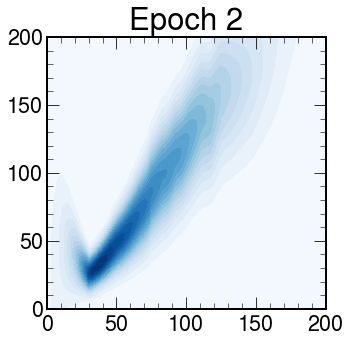

	Step: 0, loss: 9.875263214111328
	Step: 1000, loss: 10.035806655883789
Epoch 3: loss: 9.936223983764648


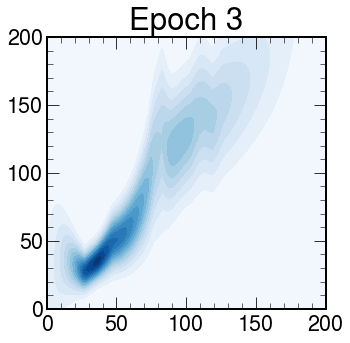

	Step: 0, loss: 9.815853118896484
	Step: 1000, loss: 9.714582443237305
Epoch 4: loss: 9.755366325378418


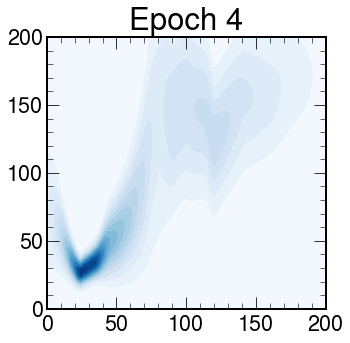

	Step: 0, loss: 10.278493881225586
	Step: 1000, loss: 9.791081428527832
Epoch 5: loss: 9.825374603271484


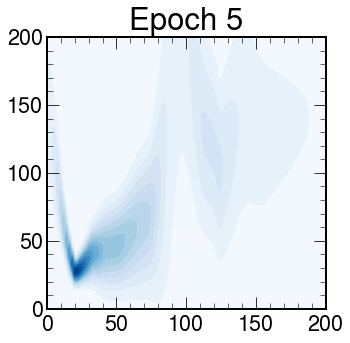

	Step: 0, loss: 10.99854564666748
	Step: 1000, loss: 9.70881175994873
Epoch 6: loss: 9.715032577514648


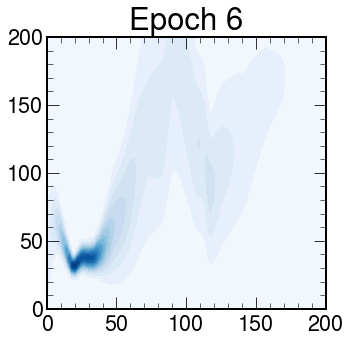

	Step: 0, loss: 10.622364044189453
	Step: 1000, loss: 9.78062915802002
Epoch 7: loss: 9.806568145751953


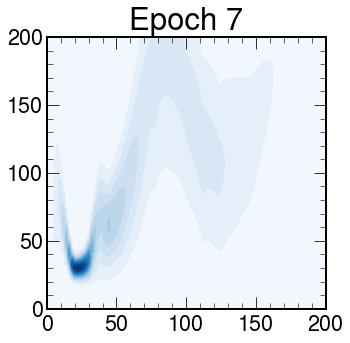

	Step: 0, loss: 10.013047218322754
	Step: 1000, loss: 9.705608367919922
Epoch 8: loss: 9.7010498046875


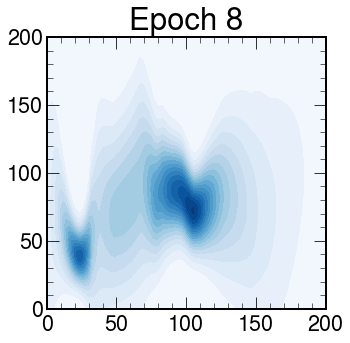

	Step: 0, loss: 10.02676010131836
	Step: 1000, loss: 9.743829727172852
Epoch 9: loss: 9.808225631713867


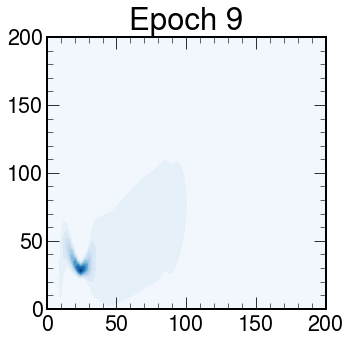

In [29]:
n_epochs = 10 # or whatever
batch_size = 1024 # or whatever
X = torch.tensor(inputs_pts, dtype=torch.float32)


for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(X.size()[0])
    
    losses_epoch = 0.
    nsteps = floor(X.size()[0]/ batch_size)
    for i in range(0,nsteps):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x = X[indices]

        # in case you wanted a semi-full example
        
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x).mean()
        loss.backward()
        optimizer.step()
        losses_epoch += loss
        
        if i%1000 == 0:
            print(f"\tStep: {i}, loss: {loss}")
        
    print(f"Epoch {epoch}: loss: {losses_epoch/nsteps}")
    plot_density(flow, f"Epoch {epoch}", [0,200],[0,200])
                
        #print(loss)
        #plot_density(flow)

In [155]:
samples[:,0]

array([ -4.253688 , 144.86195  , 106.1703   , ..., 112.80568  ,
        -4.3910584, 112.71237  ], dtype=float32)

Text(1, 0, 'Parton Pt')

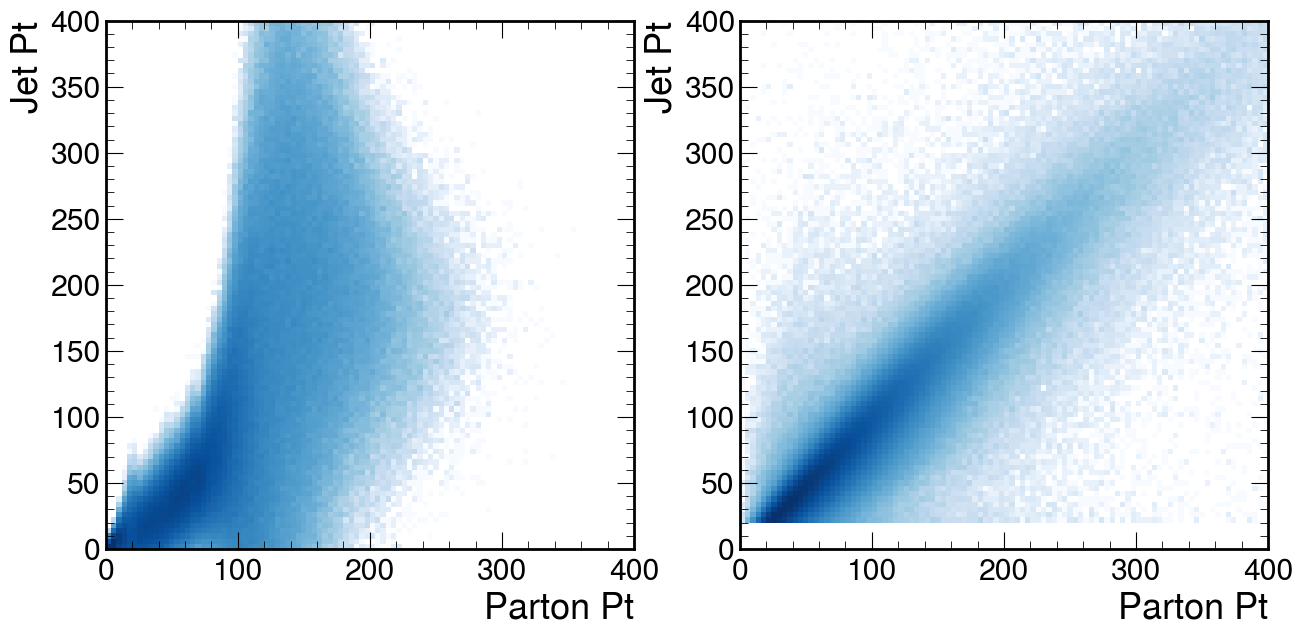

In [32]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(15, 7), dpi=100)

samples = flow.sample(1000000).detach().numpy()

count, xbins,ybins, im = ax.hist2d(samples[:,0],samples[:,1], bins=100, range=((0,400),(0, 400) ), norm=LogNorm(),cmap="Blues")
ax.set_ylabel("Jet Pt")
ax.set_xlabel("Parton Pt")
#ax.contour(count, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())


count, xbins,ybins, im = ay.hist2d(inputs_pts[:,0],inputs_pts[:,1], bins=100, range=((0,400),(0, 400) ), norm=LogNorm(),cmap="Blues")
ay.set_ylabel("Jet Pt")
ay.set_xlabel("Parton Pt")
#ay.contour(count, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())


In [57]:
samples

array([[ 58.82751 ,  53.799824],
       [ 61.864452,  51.07894 ],
       [152.68604 , 126.14025 ],
       ...,
       [ 99.90926 , 117.23747 ],
       [137.21477 , 139.95152 ],
       [135.51067 , 120.13834 ]], dtype=float32)

In [2]:
from nflows.transforms import made

In [3]:
made._get_input_degrees(10)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [68]:
features = 10
hidden_features = 128
random_mask = True

In [69]:
mm = made.MaskedLinear(
            in_degrees=made._get_input_degrees(hidden_features),
            out_features=hidden_features,
            autoregressive_features=features,
            random_mask=random_mask,
            is_output=False,
        )

In [70]:
mm

MaskedLinear(in_features=128, out_features=128, bias=True)

In [71]:
mm.mask[0:10].numpy()

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [72]:
mm.degrees


tensor([7, 3, 8, 2, 1, 1, 8, 8, 3, 5, 1, 7, 9, 3, 9, 3, 2, 7, 8, 7, 6, 5, 6, 4,
        2, 6, 9, 7, 1, 5, 8, 4, 6, 7, 1, 5, 8, 3, 6, 1, 8, 4, 3, 2, 4, 4, 1, 5,
        3, 9, 3, 6, 4, 9, 8, 1, 3, 3, 2, 7, 2, 2, 1, 6, 1, 1, 8, 3, 4, 5, 2, 2,
        6, 7, 9, 4, 2, 4, 8, 1, 4, 1, 1, 4, 7, 5, 3, 4, 1, 4, 6, 2, 3, 5, 4, 8,
        2, 1, 2, 1, 4, 3, 1, 1, 1, 1, 3, 9, 3, 7, 6, 6, 5, 6, 2, 8, 1, 6, 9, 4,
        7, 2, 5, 3, 4, 9, 1, 9])

In [14]:
from nflows.utils import torchutils

In [17]:
torchutils.tile(
                made._get_input_degrees(2),
                3)

tensor([1, 1, 1, 2, 2, 2])

In [18]:
made._get_input_degrees(2),

(tensor([1, 2]),)